# Курс "Аналитик данных" Project 2. Анализ воронки

## ЦЕЛИ ИССЛЕДОВАНИЯ ПРОЕКТА:


1. **Проверить, отличается ли время прохождения различных этапов для пользователей, которые прошли обучение, от пользователей, не начинавших обучение.** Насколько обучение сокращает время прохождения этапов?


2. **Посмотреть, существует ли зависимость между вероятностью оплаты вопросов и количеством обучений, которые начинал или завершал пользователь.** Нужно доказать, что успешное обучение само по себе влияет на оплату, и без разницы, каким этапом оно шло.


3. **Выявить, как часто пользователи начинают обучение после того, как они выбрали уровень сложности?** Это позволит нам понять, насколько прозрачен процесс взаимодействия с игрой: если пользователи после выбора уровня сложности обращаются к обучению, значит, работа с приложением непонятна.

##  Предобработка данных

Перед тем как начать исследовать вышеописанные задачи, необходимо провести предобработку данных, а именно сделать выборку по пользователям зарегистрированных в 2018 году, **то есть в промежутке между 1 января и 31 декабря 2018 года включительно.**

Для этого мы создадим отдельный датафрейм по 2018 году.

In [1]:
import pandas as pd
import warnings
import numpy as np
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime
events_df = pd.read_csv('Events.csv')
purchase_df = pd.read_csv('purchase.csv')
# импорт файлов
purchase_df['event_type'] = 'purchase'
purchase_df = purchase_df.rename(columns={'id':'purchase_id'})
purchase_df = purchase_df.rename(columns={'event_datetime':'first_purchase_time'})
events_df = events_df.rename(columns={'id':'event_id'})

In [2]:
total_events_df = pd.concat([events_df,purchase_df],sort=False)
total_events_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 258290 entries, 0 to 5955
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   event_id             252334 non-null  float64
 1   event_type           258290 non-null  object 
 2   selected_level       31086 non-null   object 
 3   start_time           252334 non-null  object 
 4   tutorial_id          125103 non-null  float64
 5   user_id              258290 non-null  int64  
 6   purchase_id          5956 non-null    float64
 7   first_purchase_time  5956 non-null    object 
 8   amount               5956 non-null    float64
dtypes: float64(4), int64(1), object(4)
memory usage: 19.7+ MB


In [3]:
cond = (events_df.start_time>='2018-01-01') & (events_df.start_time<'2019-01-01') & (events_df.event_type=='registration') 
# переменной присваиваем фильтр значений, фильтр из таблицы events
registered = events_df[cond]['user_id'].to_list() 
# создаём список пользователей, зарег. в 2018
total_events_2018 = total_events_df[total_events_df.user_id.isin(registered)]
# выбор user_id в таблице purchase, по значению "registration" в столбце even_type таблицы events
total_events_2018.info()
# вывод информации

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68559 entries, 51405 to 2778
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   event_id             66959 non-null  float64
 1   event_type           68559 non-null  object 
 2   selected_level       8342 non-null   object 
 3   start_time           66959 non-null  object 
 4   tutorial_id          32954 non-null  float64
 5   user_id              68559 non-null  int64  
 6   purchase_id          1600 non-null   float64
 7   first_purchase_time  1600 non-null   object 
 8   amount               1600 non-null   float64
dtypes: float64(4), int64(1), object(4)
memory usage: 5.2+ MB


In [4]:
total_events_2018 = total_events_2018.reset_index(drop=True).sort_values('start_time')
total_events_2018.start_time = pd.to_datetime(total_events_2018.start_time, format='%Y-%m-%dT%H:%M:%S')
total_events_2018.first_purchase_time = pd.to_datetime(total_events_2018.first_purchase_time, format='%Y-%m-%dT%H:%M:%S')
total_events_2018

,event_id,event_type,selected_level,start_time,tutorial_id,user_id,purchase_id,first_purchase_time,amount
0,80308.0,registration,NaN,2018-01-01 03:48:40,NaN,27832,NaN,NaT,NaN
1,80309.0,registration,NaN,2018-01-01 04:07:25,NaN,27833,NaN,NaT,NaN
2,80310.0,registration,NaN,2018-01-01 08:35:10,NaN,27834,NaN,NaT,NaN
3,80311.0,registration,NaN,2018-01-01 11:54:47,NaN,27835,NaN,NaT,NaN
4,80312.0,registration,NaN,2018-01-01 13:28:07,NaN,27836,NaN,NaT,NaN
...,...,...,...,...,...,...,...,...,...
68554,NaN,purchase,NaN,NaT,NaN,47498,18441.0,2019-01-02 03:48:19,100.0
68555,NaN,purchase,NaN,NaT,NaN,47647,18442.0,2019-01-02 23:26:26,150.0
68556,NaN,purchase,NaN,NaT,NaN,47554,18443.0,2019-01-03 00:36:36,50.0
68557,NaN,purchase,NaN,NaT,NaN,47742,18448.0,2019-01-04 12:51:41,50.0


Мы провели выгрузку файлов, проверили то что всё правильно выгрузилось при помощи **.info()** и **.head().**

## Вопрос 1. Проверить, отличается ли время прохождения различных этапов для пользователей, которые прошли обучение, от пользователей, не начинавших обучение. 

Для того что бы узнать как отличается время прохождения этапов для 2-х групп пользователей нам необходимо:
- определить время прохождения этапов для пользователей прошедших обучение. Этапами выделяем следующие: регистрация - выбор уровня сложности - выбор пакета - покупка пакета;
- определить время прохождения этапов для пользователей не прошедших обучение;
- сравнить показатели;
- построить столбчатый график для дополнительной визуализации.

In [5]:
registration_df = total_events_2018[total_events_2018['event_type'] == 'registration']
print(registration_df['user_id'].value_counts().mean())
# проверяем на наличие дубликатов в данных по событию registration
registration_df = registration_df[['user_id','start_time']].rename(columns={'start_time':'registration_time'})
# переименовываем в получившемся датафрейме столбец start_time на registration_time

1.0


In [6]:
level_choice_df = total_events_2018[total_events_2018['event_type'] == 'level_choice']
# выбор в таблице total_events_2018, по значению "level_choice" в столбце even_type таблицы
print(level_choice_df['user_id'].value_counts().mean())
# вывод результата поиска дубликатов
level_choice_df = level_choice_df[['user_id','start_time']].rename(columns={'start_time':'level_choice_time'})
# переименовываем в получившемся датафрейме столбец start_time на level_choice_time
merged_df = registration_df.merge(level_choice_df,on='user_id',how='left')
# объединяем таблицы друг к другу
merged_df['delta_reg_lvl_choi'] = merged_df['level_choice_time'] - merged_df['registration_time']
merged_df.drop(['registration_time', 'level_choice_time'], axis=1, inplace=True)
merged_df['delta_reg_lvl_choi'].describe()

1.0


count                         8342
mean     0 days 07:10:19.169863342
std      0 days 04:33:51.164488800
min                0 days 00:08:15
25%         0 days 03:53:16.500000
50%                0 days 06:03:28
75%         0 days 09:34:58.500000
max                1 days 18:48:25
Name: delta_reg_lvl_choi, dtype: object

In [7]:
pack_choice_df = total_events_2018[total_events_2018['event_type'] == 'pack_choice']
# выбор в таблице total_events_2018, по значению "pack_choice" в столбце even_type таблицы
print(pack_choice_df['user_id'].value_counts().mean())
# вывод результата поиска дубликатов
pack_choice_df = pack_choice_df[['user_id','start_time']].rename(columns={'start_time':'pack_choice_time'})
# переименовываем в получившемся датафрейме столбец start_time на pack_choice_time
merged_df_2 = level_choice_df.merge(pack_choice_df,on='user_id',how='left')
# объединение датафреймов
merged_df_2['delta_lvl_choi_p_choi'] = merged_df_2['pack_choice_time'] - merged_df_2['level_choice_time']
# вычисление разницы между временем выбора уровня и временем регистрации
merged_df_2.drop(['pack_choice_time', 'level_choice_time'], axis=1, inplace=True)
merged_df_2['delta_lvl_choi_p_choi'].describe()

1.0


count                         5737
mean     0 days 00:05:17.128464354
std      0 days 00:02:43.923107804
min                0 days 00:00:19
25%                0 days 00:03:05
50%                0 days 00:04:57
75%                0 days 00:07:08
max                0 days 00:15:48
Name: delta_lvl_choi_p_choi, dtype: object

In [8]:
first_purchase_df = total_events_2018[total_events_2018['event_type'] == 'purchase']
# выбор в таблице total_events_2018, по значению "purchase" в столбце even_type таблицы
print(first_purchase_df['user_id'].value_counts().mean())
# вывод результата поиска дубликатов
merged_df_3 = first_purchase_df.merge(pack_choice_df,on='user_id',how='left')
# объединение датафреймов
merged_df_3['delta_p_choi_purch'] = merged_df_3['first_purchase_time'] - merged_df_3['pack_choice_time']
# вычисление разницы между временем выбора уровня и временем регистрации
merged_df_3.drop(['event_id','event_type','selected_level','start_time','tutorial_id','purchase_id', 
                  'amount','first_purchase_time','pack_choice_time'], axis=1, inplace=True) 
merged_df_3['delta_p_choi_purch'].describe()

1.0


count                         1600
mean        3 days 17:46:53.403125
std      2 days 04:37:20.225124289
min                0 days 00:44:50
25%         1 days 21:24:13.250000
50%         3 days 12:51:25.500000
75%         5 days 09:42:13.750000
max               10 days 18:33:59
Name: delta_p_choi_purch, dtype: object

In [9]:
total_events_2018[total_events_2018['tutorial_id'] > 0]
user_with_tutorial = total_events_2018[total_events_2018['event_type'] == 'tutorial_start']
user_with_tutorial.drop(['event_id','event_type','selected_level','start_time','purchase_id', 'first_purchase_time','amount'],
                        axis=1, inplace=True)
user_with_tutorial = user_with_tutorial.drop_duplicates('user_id')
# удаляем дубликаты оставляя первый входимый результат присваивая другое имя
user_with_tutorial['completed_tutorial'] = 'complete'
user_with_tutorial.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11858 entries, 7 to 66954
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tutorial_id         11858 non-null  float64
 1   user_id             11858 non-null  int64  
 2   completed_tutorial  11858 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 370.6+ KB


In [10]:
all_merged_df = merged_df.merge(merged_df_2,on='user_id',how='left')
all_merged_df = all_merged_df.merge(merged_df_3,on='user_id',how='left')
all_merged_df = all_merged_df.merge(user_with_tutorial, on='user_id',how='left')
all_merged_df.completed_tutorial = all_merged_df.completed_tutorial.fillna('not complete')
all_merged_df.head()

,user_id,delta_reg_lvl_choi,delta_lvl_choi_p_choi,delta_p_choi_purch,tutorial_id,completed_tutorial
0,27832,NaT,NaT,NaT,NaN,not complete
1,27833,NaT,NaT,NaT,31508.0,complete
2,27834,NaT,NaT,NaT,31510.0,complete
3,27835,0 days 08:42:35,0 days 00:01:21,NaT,31506.0,complete
4,27836,NaT,NaT,NaT,31505.0,complete


In [11]:
all_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19926 entries, 0 to 19925
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype          
---  ------                 --------------  -----          
 0   user_id                19926 non-null  int64          
 1   delta_reg_lvl_choi     8342 non-null   timedelta64[ns]
 2   delta_lvl_choi_p_choi  5737 non-null   timedelta64[ns]
 3   delta_p_choi_purch     1600 non-null   timedelta64[ns]
 4   tutorial_id            11858 non-null  float64        
 5   completed_tutorial     19926 non-null  object         
dtypes: float64(1), int64(1), object(1), timedelta64[ns](3)
memory usage: 1.1+ MB


In [12]:
group = all_merged_df.groupby(['completed_tutorial']).describe().transpose().reset_index()
users = round(group[group['level_0'].str.contains('delta')&group['level_1'].
        str.contains('mean')].loc[:,['complete','not complete']].reset_index().drop('index', axis = 1)/pd.Timedelta('1M'),2)
users

completed_tutorial,complete,not complete
0,431.68,315.55
1,5.28,5.40
2,5377.65,6049.56


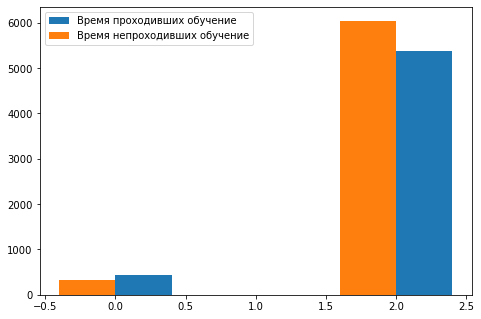

In [13]:
fig = plt.figure()
axes = fig.add_axes ([0, 0, 1, 1])
axes.bar (x= users.index, height = users['complete'], 
          width = 0.4, align = 'edge', label = 'Время проходивших обучение',)
axes.bar (x= users.index, height = users['not complete'],
          width = -0.4, align = 'edge',label = 'Время непроходивших обучение')
axes.legend(loc=2)

## Выводы

Время, которое затрачиваются пользователями 2-х групп (проходивших и непроходивших обучение) для перехода между этапами:
- различается в двух временных диапазонах: между регистрацией - выбором уровня сложности (431.68 минут и 315.55 минут соответственно) и выбором пакета вопросов - покупкой пакета (5377.65 минут и 6049.56 минут соответственно)
- время между выбором уровня сложности - выбором пакета вопросов практически не отличается(5.28 минут и 5.40 минут соответственно)

По итогам данных можно сделать вывод: затраты времени на **прохождение обучения**, в среднем 116.13 минут, **позволяет быстрее пройти весь путь до покупки**, в среднем на 671.91 минут. 

## Вопрос 2. Посмотреть, существует ли зависимость между вероятностью оплаты вопросов и количеством обучений, которые начинал или завершал пользователь. 

Для того что бы узнать есть ли зависимость между количеством обучений и вероятностью оплаты необходимо:
- определить пути при которых пользователь производил оплату для покупки пакета;
- определяем количество пользователей которые начали обучение, завершили обучение и совершили покупку;
- сегментируем наших пользователей по признаку;
- вычисляем процент совершения покупки пользователями из разных сегментов;
- построить график зависимости прохождения обучения и совершения покупки.

In [14]:
user_path_2018 = total_events_2018.groupby(['user_id'])['event_type'].apply(list).reset_index()
user_path_2018.head(10)

,user_id,event_type
0,27832,[registration]
1,27833,"[registration, tutorial_start, tutorial_finish]"
2,27834,"[registration, tutorial_start, tutorial_finish]"
3,27835,"[registration, tutorial_start, tutorial_finish..."
4,27836,"[registration, tutorial_start, tutorial_start,..."
5,27837,[registration]
6,27838,[registration]
7,27839,"[registration, tutorial_start, tutorial_finish..."
8,27840,"[registration, tutorial_start, level_choice]"
9,27841,"[registration, tutorial_start, tutorial_finish]"


Из данных видим что путей, по которым пользователи проходят разнятся для каждого из них. Для этого определим количество действий: **tutorial_start, tutorial_finish, purchase** для каждого из них.

In [15]:
users_tutorial_start = total_events_2018.groupby(['user_id'])['event_type'].apply(lambda x: (x=='tutorial_start').\
    sum()).reset_index().rename(columns={"event_type": "Tutorial_start_count"})

In [16]:
users_tutorial_finish = total_events_2018.groupby(['user_id'])['event_type'].apply(lambda x: (x=='tutorial_finish').\
    sum()).reset_index().rename(columns={"event_type": "Tutorial_finish_count"})

In [17]:
users_purchase = total_events_2018.groupby(['user_id'])['event_type'].apply(lambda x: (x=='purchase').\
    sum()).reset_index().rename(columns={"event_type": "Purchase_count"})

In [18]:
users_tutorial_w_purchase = users_tutorial_start.merge(users_tutorial_finish, on = 'user_id', how = 'inner')
users_tutorial_w_purchase = users_tutorial_w_purchase.merge(users_purchase, on = 'user_id', how = 'inner')

In [19]:
users_tutorial_w_purchase.head()

,user_id,Tutorial_start_count,Tutorial_finish_count,Purchase_count
0,27832,0,0,0
1,27833,1,1,0
2,27834,1,1,0
3,27835,1,1,0
4,27836,2,1,0


Группируем наши данные по параметрам **Tutorial_start_count** и **Tutorial_finish_count** что бы получить количество покупок совершивших пользователями начавшими и незавершившими обучение, для дальнейшего получения **процента покупок** по категориям прохождения обучений, что по сути будет и являться нашей **вероятностью совершения покупки**.

In [20]:
group_Tutorial_start_count = users_tutorial_w_purchase.groupby(['Tutorial_start_count']).\
        agg({'user_id': 'count', 'Purchase_count': 'sum'}).reset_index()
group_Tutorial_finish_count = users_tutorial_w_purchase.groupby(['Tutorial_finish_count']).\
        agg({'user_id': 'count', 'Purchase_count': 'sum'}).reset_index()

In [21]:
group_Tutorial_start_count['users_percent'] = round(
    group_Tutorial_start_count['Purchase_count']/group_Tutorial_start_count['user_id']*100, 2)
group_Tutorial_start_count

,Tutorial_start_count,user_id,Purchase_count,users_percent
0,0,8068,22,0.27
1,1,9103,1207,13.26
2,2,1589,218,13.72
3,3,427,51,11.94
4,4,221,30,13.57
5,5,109,16,14.68
6,6,116,14,12.07
7,7,94,12,12.77
8,8,86,13,15.12
9,9,113,17,15.04


In [22]:
group_Tutorial_finish_count['users_percent'] = round(
    group_Tutorial_finish_count['Purchase_count']/group_Tutorial_finish_count['user_id']*100, 2)
group_Tutorial_finish_count

,Tutorial_finish_count,user_id,Purchase_count,users_percent
0,0,9676,153,1.58
1,1,8015,1143,14.26
2,2,1321,182,13.78
3,3,345,44,12.75
4,4,178,19,10.67
5,5,117,19,16.24
6,6,101,15,14.85
7,7,97,15,15.46
8,8,54,6,11.11
9,9,22,4,18.18


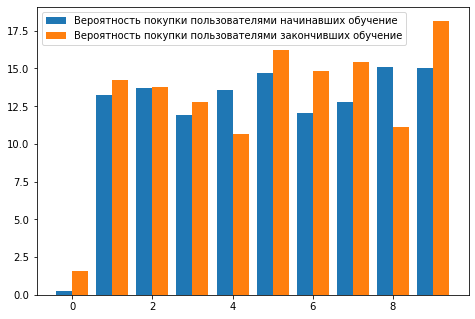

In [23]:
fig = plt.figure()
axes = fig.add_axes ([0, 0, 1, 1])
axes.bar (x= group_Tutorial_start_count.Tutorial_start_count, height = group_Tutorial_start_count['users_percent'], 
          width = -0.4, align = 'edge', label = 'Вероятность покупки пользователями начинавших обучение',)
axes.bar (x= group_Tutorial_finish_count.Tutorial_finish_count, height = group_Tutorial_finish_count['users_percent'],
          width = 0.4, align = 'edge',label = 'Вероятность покупки пользователями закончивших обучение')
axes.legend(loc=2)

## Выводы

Отвечая на постваленный вопрос отмечу:
- **Зависимости** между вероятностью оплаты и количеством пройденных обучений пользователями (начавших и закончивших) **нет**;
- В то же время чётко прослеживается что **начало или завершение хотя бы 1 обучения** значительно, на 12.99% и  12.66 % соответственно, **повышает вероятность** покупки пакета;
- **Дополнительное начало или завершение обучения** на вероятность покупки пакета **не оказывает такое существенное влияние** находясь в диапазоне +/- 4%.

## Вопрос 3. Выявить, как часто пользователи начинают обучение после того, как они выбрали уровень сложности?

Для того что бы провести наше исследование нам необходимо:
- Создать датасет со всеми событиями level_choice и tutorial_start или использовать уже имеющиеся, объединить их по параметру user_id;
- Производим группирование по нашим данным по user_id и по количеству повторных обучений;
- Подсчитываем сколько пользователей совершало повторные обучения;
- Строим график показывающий взаимосвязь между количесвтом повторных обучений и количесвтом пользователей. 

In [24]:
tutorial_start_df = total_events_2018[total_events_2018['event_type'] == 'tutorial_start']
tutorial_start_df = tutorial_start_df[['user_id','start_time']].rename(columns={'start_time':'tutorial_start_time'})
# переименовываем в получившемся датафрейме столбец start_time на tutorial_start_time
tutorial_start_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18050 entries, 7 to 66954
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              18050 non-null  int64         
 1   tutorial_start_time  18050 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 423.0 KB


In [25]:
level_choice_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8342 entries, 19 to 66957
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            8342 non-null   int64         
 1   level_choice_time  8342 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 195.5 KB


In [26]:
retraining_df = level_choice_df.merge(tutorial_start_df, on = 'user_id', how = 'inner')
retraining_df = retraining_df.loc[retraining_df['level_choice_time'] < retraining_df['tutorial_start_time']]
retraining_df

,user_id,level_choice_time,tutorial_start_time
4,27845,2018-01-02 06:19:18,2018-01-02 07:08:00
6,27842,2018-01-02 08:46:03,2018-01-02 09:01:51
7,27842,2018-01-02 08:46:03,2018-01-02 18:08:01
13,27852,2018-01-02 18:39:44,2018-01-02 20:34:31
19,27862,2018-01-03 04:19:32,2018-01-03 11:17:41
...,...,...,...
12626,47635,2018-12-28 11:43:38,2018-12-28 17:28:42
12640,47657,2018-12-28 21:25:49,2018-12-28 21:44:13
12641,47657,2018-12-28 21:25:49,2018-12-28 21:53:06
12664,47711,2018-12-29 21:23:23,2018-12-29 22:50:57


In [27]:
retraining_users = retraining_df.groupby(['user_id'])['tutorial_start_time'].count().reset_index()
№
retraining_users = retraining_users.groupby(['tutorial_start_time'])['user_id'].count().reset_index()
retraining_users['percent_of_all_tutorial'] = round(retraining_users['user_id'] / len(tutorial_start_df)*100, 2)
retraining_users

,tutorial_start_time,user_id,percent_of_all_tutorial
0,1,819,4.54
1,2,229,1.27
2,3,116,0.64
3,4,77,0.43
4,5,57,0.32
5,6,51,0.28
6,7,28,0.16
7,8,9,0.05


Text(0.5, 1.0, 'Отношение % пользователей начавших повторные обучения к кол-ву повторных обучений')

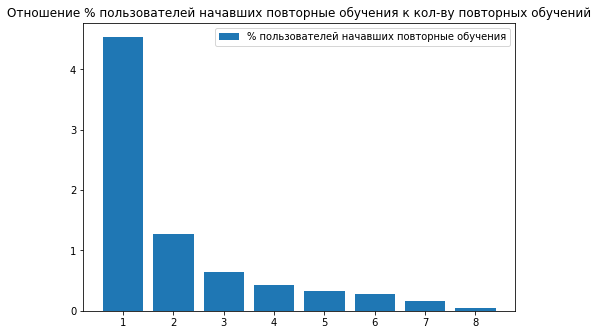

In [28]:
fig = plt.figure()
axes = fig.add_axes ([0, 0, 1, 1])
axes.bar (x= retraining_users['tutorial_start_time'], height = retraining_users['percent_of_all_tutorial'],
          label = '% пользователей начавших повторные обучения',)
axes.legend(loc=1)
axes.set_title('Отношение % пользователей начавших повторные обучения к кол-ву повторных обучений')

## Выводы

Исходя из полученных данных можно сделать вывод что **7.69 %** всех **пользователей** которые начинали обучение, **возвращаются** к нему **повторно**. Самый большой процент у пользователей которые проходят 1 дополнительное обучение, остальных пользователей меньше.

## Предложения по оптимизации

Из полученных данных можем сделать вывод что **для** тех **людей кто не проходит обучение игра менее дружелюбна**, в связи с чем могут падать и доходы от покупок пакетов. **Рекомендуется сделать обязательным прохождение обучения, что позволит** на дистанции **иметь лояльных клиентов и стабильный доход** от данной игры.